In [1]:
import os
import gc
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# The goal of this notebook
1. Understanding competition
2. Understanding data
3. Understanding Evaluation

# 1. The goal of Competition

Goal: Build a model that forecasts an investment's return rate

# 2. Data

In [2]:
%%time

# from https://www.kaggle.com/valleyzw/ubiquant-lgbm-baseline
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


train = reduce_mem_usage(pd.read_parquet('../input/ubiquant-parquet/train_low_mem.parquet'))

for col in ['time_id', 'investment_id']:
    train[col] = train[col].astype(int)

Memory usage of dataframe is 3642.99 MB


  0%|          | 0/304 [00:00<?, ?it/s]

Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%
CPU times: user 1min 46s, sys: 2min 21s, total: 4min 8s
Wall time: 4min 10s


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(301), int64(2)
memory usage: 1.9 GB


### Data information

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: category(1), float16(301), int64(2)
memory usage: 1.9 GB


In [5]:
train.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300781,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0_2,0,2,-0.231079,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0_6,0,6,0.568848,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,0_7,0,7,-1.064453,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0_8,0,8,-0.531738,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793


In [6]:
print('each column info')

print('row_id: unique row id')
print('time_id: The ID code for the time the data was gathered.')
print('investment_id: investment id')
print('target: target feature')
print('f_0 ~ f_299: 300 of feature')

each column info
row_id: unique row id
time_id: The ID code for the time the data was gathered.
investment_id: investment id
target: target feature
f_0 ~ f_299: 300 of feature


In [7]:
# row_id
# row_id: "row_id" + "_" + "investment_id" !!
print(f"Length of unique row_id: {len(train['row_id'].unique())}")
print(f"start: {list(train['row_id'])[0]}, end: {list(train['row_id'])[-1]}")

Length of unique row_id: 3141410
start: 0_1, end: 1219_3773


In [8]:
# time_id
print(f"Length of unique time_id: {len(train['time_id'].unique())}")
print(f"start: {list(train['time_id'])[0]}, end: {list(train['time_id'])[-1]}")

Length of unique time_id: 1211
start: 0, end: 1219


In [9]:
# investment_id
print(f"Length of unique investment_id: {len(train['investment_id'].unique())}")
print(f"start: {list(train['investment_id'])[0]}, end: {list(train['investment_id'])[-1]}")

Length of unique investment_id: 2788
start: 1, end: 3772


In [10]:
check_row_id = train['time_id'].astype(str) + "_" + train['investment_id'].astype(str)

In [11]:
# Check the row_id assumption
if (train['row_id'] == check_row_id).sum() == train.shape[0]:
    print('row_id assumption is True')
else:
    print('row_id assumption is False')

row_id assumption is False


In [12]:
# target info
train['target'].describe()

count    3.141410e+06
mean              NaN
std      0.000000e+00
min     -9.421875e+00
25%     -5.004883e-01
50%     -9.716797e-02
75%      3.571777e-01
max      1.203906e+01
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='Count'>

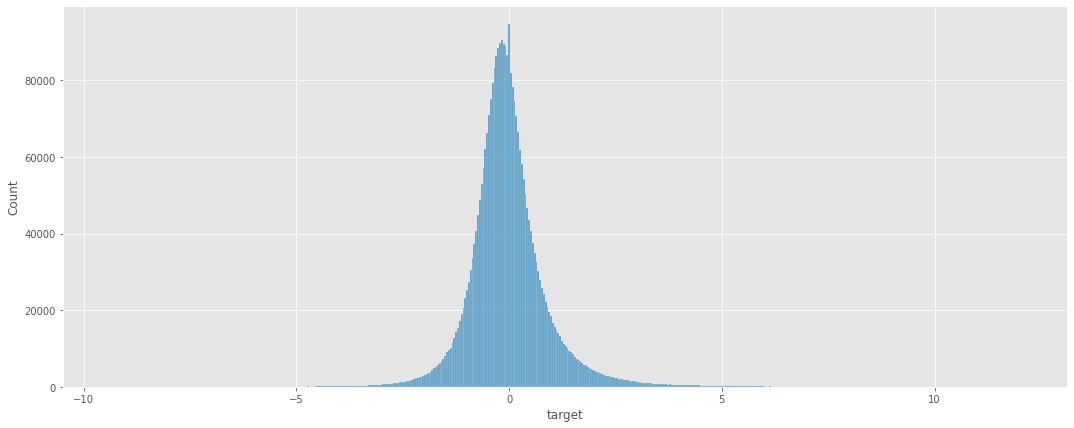

In [13]:
plt.figure(figsize = (18, 7))
sns.histplot(train['target'], bins = 500)

In [14]:
# f_0 ~ f_299 info
# feature_df = train.drop(['row_id', 'time_id', 'investment_id', 'target'], axis=1)
features = [f'f_{i}' for i in range(300)]

In [15]:
# feature_df.describe()

In [16]:
# for col in feature_df.columns[:5]:
#     plt.figure(figsize = (12, 5))
#     sns.histplot(df[col], bins = 500)

In [17]:
# add EDA
train['investment_id'].value_counts()

2752    3576
3052    3528
3304    3516
2356    3514
2712    3510
        ... 
85         8
905        8
2558       8
3662       7
1415       2
Name: investment_id, Length: 2788, dtype: int64

# Model
Linear Regression model Using sklearn 

In [18]:
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from sklearn import metrics
from scipy.stats import pearsonr

In [19]:
gc.collect()

21

In [20]:
%%time

pearsons = []
models = []

FOLDS = 5
kf = GroupKFold(n_splits=FOLDS)
for fold, (tr, val) in enumerate(kf.split(train[features], train['target'], train['time_id'])):
    gc.collect()
    print('FOLD:', fold)
    X_train = train.loc[tr, features]
    y_train = train.loc[tr, 'target']
    X_val = train.loc[val, features]
    y_val = train.loc[val, 'target']
    
    # fit
    model = linear_model.LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    models.append(model)
    
    # predict
    preds = model.predict(X_val)
    
    # metrics
    pearson = pearsonr(y_val, preds)[0]
    rmse = metrics.mean_squared_error(y_val, preds, squared=False)
    r2 = metrics.r2_score(y_val, preds)
    print('Pearson:', pearson)
    print('RMSE:', rmse)
    print('R2:', r2)
    print()
    pearsons.append(pearson)
    
print('-' * 30)
print('Mean:', np.mean(pearsons))
print('Std:', np.std(pearsons))

FOLD: 0
Pearson: 0.12683630680178548
RMSE: 0.9123466
R2: 0.016044360683544534

FOLD: 1
Pearson: 0.12751198925313467
RMSE: 0.91326505
R2: 0.016194646980616234

FOLD: 2
Pearson: 0.14243329074538724
RMSE: 0.9099416
R2: 0.020168929363318933

FOLD: 3
Pearson: 0.12142262445130798
RMSE: 0.9115411
R2: 0.014429833012276183

FOLD: 4
Pearson: 0.12866240252409275
RMSE: 0.91291666
R2: 0.01659375523611273

------------------------------
Mean: 0.12937332275514163
Std: 0.006988315782118249
CPU times: user 9min 49s, sys: 1min 24s, total: 11min 13s
Wall time: 5min 51s


# Pearson
Using `from scipy.stats import pearsonr`

return: `Pearson’s correlation coefficient`, `Two-tailed p-value`

# Submission


In [21]:
import ubiquant

env = ubiquant.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

for (test_df, sample_prediction_df) in iter_test:
    final_pred = [models[fold].predict(test_df[features]) for fold in range(FOLDS)]
    sample_prediction_df['target'] = np.mean(np.stack(final_pred), axis=0) # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions
    display(sample_prediction_df)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,row_id,target
0,1220_1,-0.140507
1,1220_2,0.001794


,row_id,target
0,1221_0,-0.096201
1,1221_1,-0.067178
2,1221_2,-0.099584


,row_id,target
0,1222_0,-0.088224
1,1222_1,-0.058137
2,1222_2,-0.152480


,row_id,target
0,1223_0,-0.049501
